# Conditional Autoencoder for Asset Pricing - Part 2: The Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


### if Colab

In [4]:
import os

if 'COLAB_GPU' in os.environ:
    print("Running on Colab")
    # Get the current working directory
    path = os.getcwd()
    # Print the path
    print("Current Path:", path)
    # 이동할 디렉토리 경로
    path = '/content/drive/MyDrive/Colab Notebooks'
    # 디렉토리 변경
    os.chdir(path)
else:
    print("Not running on Colab")

Not running on Colab


In [5]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [6]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [7]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [8]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [9]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results\asset_pricing\autoencoder.h5
/close                      frame        (shape->[7559,3825]) 
/factor/beta                frame        (shape->[2677781,1]) 
/factor/betasq              frame        (shape->[2677781,1]) 
/factor/chmom               frame        (shape->[3032594,1]) 
/factor/dolvol              frame        (shape->[3194404,1]) 
/factor/idiovol             frame        (shape->[2677781,1]) 
/factor/ill                 frame        (shape->[2880851,1]) 
/factor/indmom              frame        (shape->[3182400,1]) 
/factor/maxret              frame        (shape->[3194850,1]) 
/factor/mom12m              frame        (shape->[3032594,1]) 
/factor/mom1m               series       (shape->[3210620])   
/factor/mom36m              frame        (shape->[2676077,1]) 
/factor/mvel                frame        (shape->[3227144,1]) 
/factor/retvol              frame        (shape->[3210620,1]) 
/factor/turn                fram

### Weekly returns

In [10]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

# 램 문제 발생으로 인한 1993 -> 2013

In [11]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [12]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [13]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [14]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5393250 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3091645 non-null  float64
 1   beta         2677781 non-null  float64
 2   betasq       2677781 non-null  float64
 3   chmom        2947392 non-null  float64
 4   dolvol       3069376 non-null  float64
 5   idiovol      2677781 non-null  float64
 6   ill          2785453 non-null  float64
 7   indmom       3091645 non-null  float64
 8   maxret       3069822 non-null  float64
 9   mom12m       2947392 non-null  float64
 10  mom1m        3081787 non-null  float64
 11  mom36m       2676077 non-null  float64
 12  mvel         3094437 non-null  float64
 13  retvol       3081787 non-null  float64
 14  turn         3056929 non-null  float64
 15  turn_std     3077284 non-null  fl

In [15]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

### 주식 개수, Beta 개수

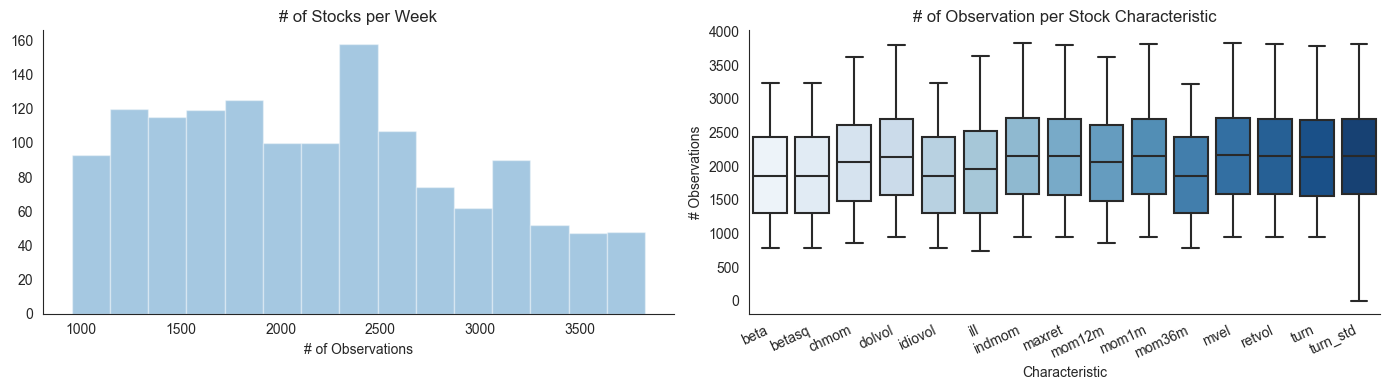

In [16]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()
    # fig.savefig(results_path / 'of Stocks per Week', dpi=600)

### Rank-normalize characteristics

In [17]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [18]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5393250 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3091645 non-null  float64
 1   beta         2677781 non-null  float64
 2   betasq       2677781 non-null  float64
 3   chmom        2947392 non-null  float64
 4   dolvol       3069376 non-null  float64
 5   idiovol      2677781 non-null  float64
 6   ill          2785453 non-null  float64
 7   indmom       3091645 non-null  float64
 8   maxret       3069822 non-null  float64
 9   mom12m       2947392 non-null  float64
 10  mom1m        3081787 non-null  float64
 11  mom36m       2676077 non-null  float64
 12  mvel         3094437 non-null  float64
 13  retvol       3081787 non-null  float64
 14  turn         3056929 non-null  float64
 15  turn_std     3077284 non-null  fl

In [19]:
data.index.names

FrozenList(['date', 'ticker'])

In [20]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,3.091645e+06,2.677781e+06,2.677781e+06,2.947392e+06,3.069376e+06,2.677781e+06,2.785453e+06,3.091645e+06,3.069822e+06,2.947392e+06,3.081787e+06,2.676077e+06,3.094437e+06,3.081787e+06,3.056929e+06,3.077284e+06,3.090691e+06
mean,3.045176e-03,-5.309169e-08,-5.146152e-07,6.963426e-09,-4.709343e-07,-2.391944e-07,-5.998247e-07,7.947761e-04,-1.238270e-07,-1.101284e-07,3.994020e-08,-1.678374e-07,-3.933234e-08,-1.024869e-06,-4.668285e-07,-9.886441e-07,3.042616e-03
std,6.134996e-02,5.776538e-01,5.776544e-01,5.776258e-01,5.776161e-01,5.776539e-01,5.776421e-01,5.879197e-01,5.776144e-01,5.776259e-01,5.776114e-01,5.776540e-01,5.776128e-01,5.776155e-01,5.776164e-01,5.776150e-01,6.135423e-02
min,-9.549180e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.549180e-01
25%,-2.155692e-02,-5.002539e-01,-5.002617e-01,-5.002054e-01,-5.001815e-01,-5.002382e-01,-5.002250e-01,-4.900628e-01,-5.002588e-01,-5.002046e-01,-5.000749e-01,-5.002558e-01,-5.001877e-01,-5.001996e-01,-5.001927e-01,-5.001929e-01,-2.156144e-02
50%,9.764409e-04,0.000000e+00,0.000000e+00,0.000000e+00,-1.110223e-16,-1.110223e-16,0.000000e+00,1.046025e-03,0.000000e+00,0.000000e+00,-1.110223e-16,0.000000e+00,-1.110223e-16,-1.110223e-16,0.000000e+00,0.000000e+00,9.764634e-04
75%,2.502054e-02,5.002418e-01,5.002408e-01,5.002116e-01,5.001990e-01,5.002417e-01,5.002108e-01,4.811715e-01,5.001784e-01,5.002182e-01,5.001866e-01,5.002496e-01,5.001930e-01,5.001858e-01,5.001975e-01,5.001834e-01,2.501880e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [21]:
data = data.loc[idx[:'2019', :], :]

In [22]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [23]:
data = data.fillna(-2)

In [24]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [25]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [26]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [27]:
n_tickers

3825

In [28]:
n_characteristics

15

### Input Layer

In [29]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [30]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [31]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [32]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [33]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [34]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 3825, 15)]   0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 3825, 8)      128         ['input_beta[0][0]']             
                                                                                                  
 batch_norm (BatchNormalization  (None, 3825, 8)     32          ['hidden_layer[0][0]']           
 )                                                                                                
                                                                                                  
 input_factor (InputLayer)      [(None, 3825)]       0           []                           

### 모델 시각화

In [36]:
# model_img_file = (results_path / 'model.png' )
# tf.keras.utils.plot_model(model, to_file=model_img_file, 
#                           show_shapes=True, 
#                           show_layer_activations=True, 
#                           show_dtype=True,
#                           show_layer_names=True )

# model.save(results_path / 'model_img.h5')

## Train Model

### Cross-validation parameters

In [37]:
YEAR = 52

In [38]:
cv = MultipleTimeSeriesCV(n_splits=5, # 5
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [39]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [46]:
factor_opts = [2, 3, 4, 5, 6] # 2, 3, 4, 5, 6
unit_opts = [32] # 8, 16, 32

In [47]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [48]:
batch_size = 256

In [49]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [50]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from keras.utils import Sequence

# Define a custom data generator to feed data to the model
class DataGenerator(Sequence):
    def __init__(self, X1, X2, y, batch_size):
        self.X1 = X1
        self.X2 = X2
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X1 = self.X1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X2 = self.X2[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X1, batch_X2], batch_y

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [51]:
start = time()
for units, n_factors in param_grid:
    print("units:", units, ", n_factors:", n_factors)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        model = make_model(hidden_units=units, n_factors=n_factors)
        for epoch in range(250):
            model.fit_generator(train_gen,
                                validation_data=val_gen,
                                epochs=epoch + 1,
                                initial_epoch=epoch, verbose=False, shuffle=True, callbacks=ClearMemory())
            y_pred = model.predict_generator(val_gen, callbacks=ClearMemory())
            y_true = y_val.stack().values
            date_index = y_val.stack().index
            result = (pd.DataFrame({'y_pred': y_pred.reshape(-1),
                                    'y_true': y_true},
                                   index=date_index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')
            
        scores = pd.DataFrame(scores, columns=cols)
        scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

units: 32 , n_factors: 2
00:00:04 | 2 | 32 | 00-000 |  1.13% |  2.21% |  0.97%
00:00:46 | 2 | 32 | 00-050 |  0.55% | -0.35% | -0.28%
00:01:26 | 2 | 32 | 00-100 |  0.40% | -0.11% | -0.23%
00:02:07 | 2 | 32 | 00-150 | -0.88% | -0.46% | -0.25%
00:02:48 | 2 | 32 | 00-200 | -0.73% | -0.20% | -0.16%
00:03:31 | 2 | 32 | 01-000 | -0.48% | -1.22% | -1.67%
00:04:14 | 2 | 32 | 01-050 | -0.20% | -0.69% |  0.27%
00:04:56 | 2 | 32 | 01-100 | -0.83% | -1.08% | -0.36%
00:05:37 | 2 | 32 | 01-150 | -1.01% | -1.24% | -1.35%
00:06:19 | 2 | 32 | 01-200 | -1.06% | -1.19% | -0.98%
00:07:02 | 2 | 32 | 02-000 |  1.20% |  0.98% |  1.55%
00:07:43 | 2 | 32 | 02-050 |  1.45% |  0.95% |  1.26%
00:08:23 | 2 | 32 | 02-100 | -0.16% | -0.70% | -0.41%
00:09:05 | 2 | 32 | 02-150 | -0.05% | -0.73% | -0.67%
00:09:46 | 2 | 32 | 02-200 | -0.65% | -1.33% | -0.69%
00:10:29 | 2 | 32 | 03-000 | -2.03% | -1.35% | -1.24%
00:11:10 | 2 | 32 | 03-050 |  0.85% |  0.69% | -0.23%
00:11:51 | 2 | 32 | 03-100 |  1.15% |  1.00% |  0.14%
00:

### Evaluate Results

In [52]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
print(scores)
scores = pd.concat(scores)

[     units  n_factors  fold  epoch   ic_mean  ic_daily_mean  ic_daily_std  \
0        8          2     0      0  0.027923      -0.001603      0.077540   
1        8          2     0      1  0.027612       0.003124      0.075661   
2        8          2     0      2  0.028143       0.011055      0.068375   
3        8          2     0      3  0.024787       0.010616      0.068812   
4        8          2     0      4  0.031027       0.008218      0.068623   
..     ...        ...   ...    ...       ...            ...           ...   
245      8          2     0    245 -0.055260       0.008629      0.058061   
246      8          2     0    246 -0.047854       0.008286      0.057883   
247      8          2     0    247 -0.055439       0.008547      0.058135   
248      8          2     0    248 -0.046051       0.008120      0.057348   
249      8          2     0    249 -0.064400       0.009195      0.058378   

     ic_daily_median  
0           0.004001  
1           0.006257  
2    

In [53]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            3750 non-null   int64  
 1   n_factors        3750 non-null   int64  
 2   fold             3750 non-null   int64  
 3   epoch            3750 non-null   int64  
 4   ic_mean          3750 non-null   float64
 5   ic_daily_mean    3750 non-null   float64
 6   ic_daily_std     3750 non-null   float64
 7   ic_daily_median  3750 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 263.7 KB


In [54]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [55]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
80,2,8,80,0.016350,0.033598,0.036727
81,2,8,81,0.014830,0.033179,0.036606
1610,4,8,110,0.014688,0.015893,0.032187
82,2,8,82,0.009944,0.031508,0.032081
76,2,8,76,0.018618,0.033552,0.032012
134,2,8,134,-0.004657,0.026652,0.031985
135,2,8,135,-0.005692,0.026621,0.031972
83,2,8,83,0.005299,0.029144,0.031594
136,2,8,136,-0.006684,0.026502,0.031562
79,2,8,79,0.010723,0.030385,0.031457


In [56]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
2         8              2      8     80  0.016350       0.033598   
          8              2      8     81  0.014830       0.033179   
4         8              4      8    110  0.014688       0.015893   
2         8              2      8     82  0.009944       0.031508   
          8              2      8     76  0.018618       0.033552   

                 ic_daily_median  
n_factors units                   
2         8             0.036727  
          8             0.036606  
4         8             0.032187  
2         8             0.032081  
          8             0.032012

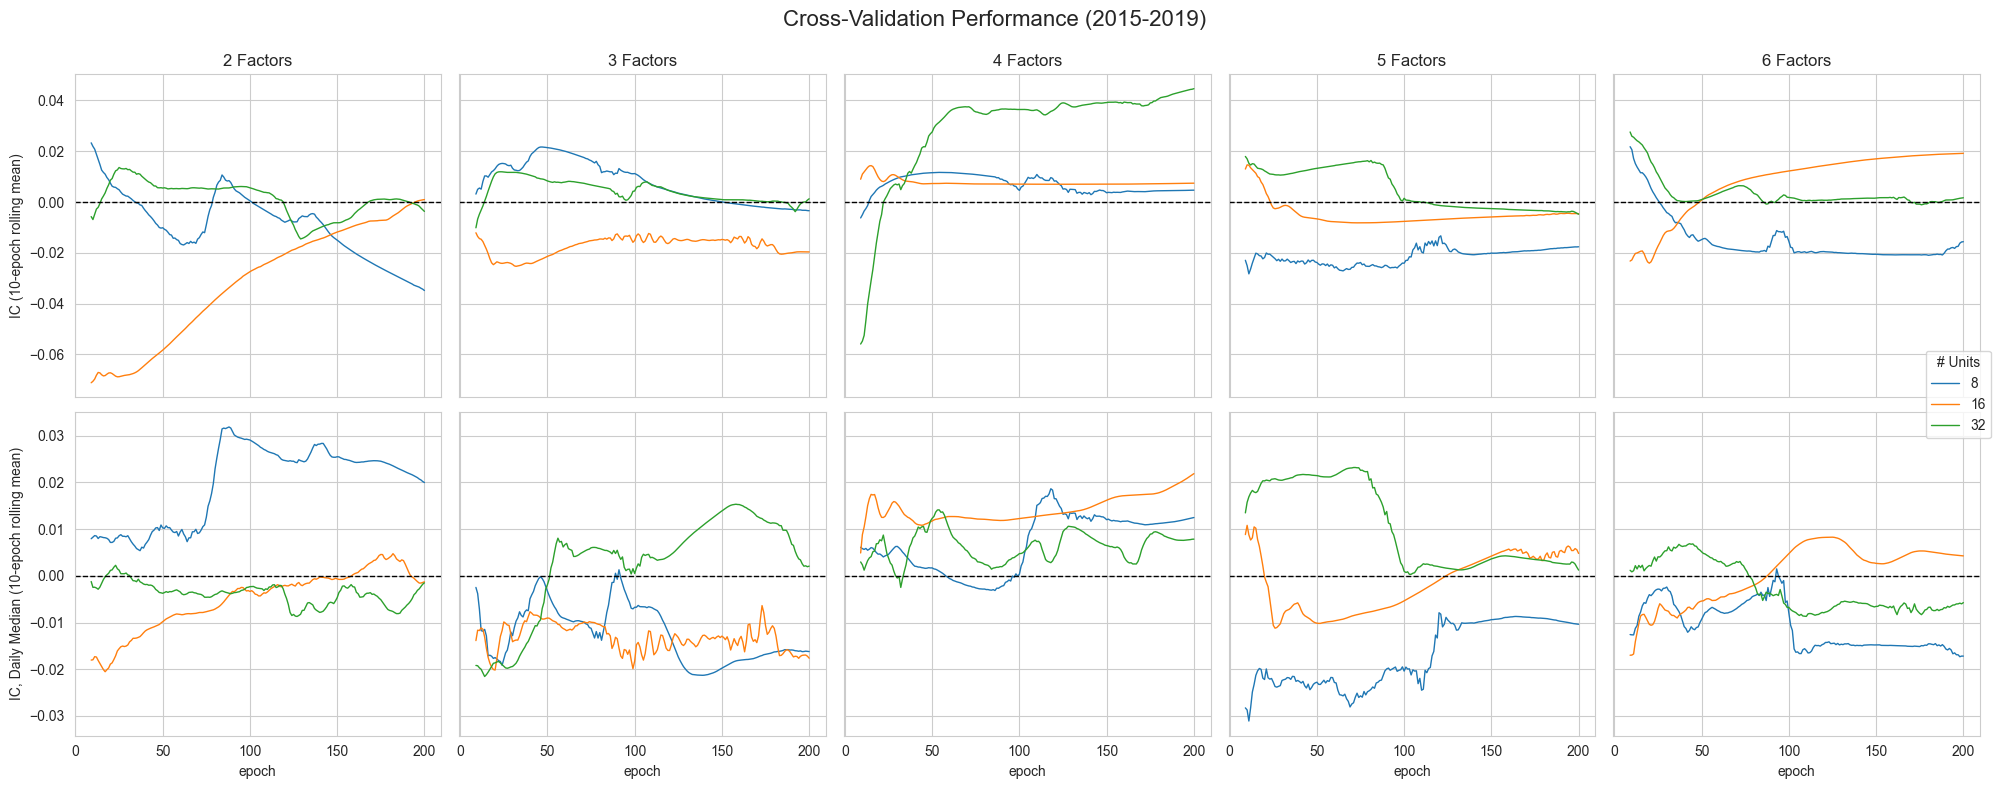

In [57]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [58]:
n_factors = 4
units = 32
batch_size = 256
first_epoch = 50
last_epoch = 80

In [59]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=False,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|          | 0/30 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  3%|▎         | 1/30 [01:19<38:15, 79.16s/it]

2/2 [==============================] - 0s 4ms/step


  3%|▎         | 1/30 [01:48<52:29, 108.62s/it]


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/batch_norm/moments/BroadcastTo_1' defined at (most recent call last):
    File "C:\Users\chldl\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\chldl\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\chldl\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\chldl\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\chldl\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\chldl\AppData\Local\Temp\ipykernel_31588\4285107039.py", line 13, in <module>
      model.fit_generator(train_gen,
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\chldl\Desktop\Study\2022-2\Capston_design\Capston_CodeSpace\capston\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/batch_norm/moments/BroadcastTo_1'
OOM when allocating tensor with shape[256,3825,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/batch_norm/moments/BroadcastTo_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_979910]

In [ ]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [ ]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 596700 entries, (Timestamp('2017-01-06 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYXI')
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   50      596700 non-null  float32
 1   51      596700 non-null  float32
 2   52      596700 non-null  float32
 3   53      596700 non-null  float32
 4   54      596700 non-null  float32
 5   55      596700 non-null  float32
 6   56      596700 non-null  float32
 7   57      596700 non-null  float32
 8   58      596700 non-null  float32
 9   59      596700 non-null  float32
 10  60      596700 non-null  float32
 11  61      596700 non-null  float32
 12  62      596700 non-null  float32
 13  63      596700 non-null  float32
 14  64      596700 non-null  float32
 15  65      596700 non-null  float32
 16  66      596700 non-null  float32
 17  67      596700 non-null  float32
 18  68      596700 non-null  float32
 19  69      5967

In [ ]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')